In [1]:
# Load Pandas into Python
import pandas as pd
from matplotlib import pyplot as plt
 
%matplotlib inline

In [8]:
# Read data
prices = pd.read_csv('prices-split-adjusted.csv')

Examine for missing data
Narrow down list of stocks for analysis

In [9]:
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [10]:
prices['symbol'].value_counts().head()

COO      1762
CMCSA    1762
UNP      1762
WFC      1762
MET      1762
Name: symbol, dtype: int64

In [11]:
print (prices['date'].max())
print (prices['date'].min())


2016-12-30
2010-01-04


Explore "next day trading."  Open position (Buy/Sell) stock at close price. Close position during next trading day.
Can we come up with a model that predicts consistent gains? What patterns if any can we find in historic data?  This is a short term model that does not look back far in history.  Does it work for random time samples/backtests?  Does it beat the market or would we have done better just trading SPX?

Data Set: https://www.kaggle.com/camnugent/sandp500
        S&P 500 Stocks OHLC data from Jan 4, 2010 - Dec 30, 2016
Assumptions: Represents all trading days in sequence. No missing trading days.

Cleaning Data:
    Only include stocks that exist on first and last day of data set.  This eliminates need to worry about delisted stocks, mergers/acqisitions or S&P delisting, .  Try it without this first.  Note nature of S&P is large cap only and success in staying there presents some bias. (see class lecture) Won't include newer stocks, like FB.
    Use stock adjusted data.  Accounts for stock splits and dividends?  Do we need this if we ignore outliers, these changes would only effect one day. 

Eliminate outliers (big moves). Do not trade when a big move is likely.  Assumption is that big moves can be avoided or do not occur often. Do not trade on earnings/election day, etc.

EDA:
Questions:
Statistics for all stocks. Mean, Stdev
1. Are certain days of the week more likely to be up or down?  Need to associate date with Day of Week.
2. Is there a correlation with the Market - may need SPX data
3. How do we group stocks (P/E, Sector) do we have fundamental data?
4. Is there a releationship for months of the year? (like in class, bikes example for hours of day)  Is it consistent year to year?
5. How does volume relate to outliers?

Model:
Possible Feature Variables: 
% change from open to close - current day.
% change from previous close
3 day trend linear correlation

Predict:
% likely to open position (buy/sell)

Test at random.


In [34]:
stocks = prices['symbol'].unique()
prices.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [39]:
gr = prices.groupby('symbol')
gr.describe()

close         high          low         open        volume
symbol                                                                        
A      count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
       mean     34.080221    34.414842    33.714101    34.065290  3.927589e+06
       std       7.439467     7.446296     7.436754     7.438918  2.384677e+06
       min      19.291845    19.706724    19.084406    19.334765  5.880000e+05
       25%      27.687768    28.074034    27.421316    27.703863  2.297950e+06
       50%      34.332382    34.651903    33.844778    34.215157  3.398250e+06
       75%      40.559486    40.885194    40.177918    40.559486  4.890125e+06
       max      48.439999    48.630001    48.119999    48.630001  2.536860e+07
AAL    count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
       mean     23.873768    24.283933    23.466453    23.875108  9.354038e+06
       std      15.557106    15.752355    15.346569    15.555224  6.361233e+06
       min       4.000000     4.060000     3.960000     3.990000  1.158400e+06
       25%       9.332500     9.640000     9.170000     9.405000  5.915950e+06
       50%      17.224999    17.449999    16.960000    17.155000  8.078550e+06
       75%      39.349998    39.997501    38.730002    39.292499  1.108758e+07
       max      55.759998    56.200001    54.860001    55.889999  1.377672e+08
AAP    count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
       mean    103.769597   104.800505   102.685749   103.724540  1.022026e+06
       std      43.410717    43.853331    42.966318    43.422217  7.632007e+05
       min      39.160000    39.380001    38.380001    38.750000  1.307000e+05
       25%      66.465000    67.135000    65.964998    66.445001  6.274250e+05
       50%      84.584999    85.489998    83.989998    84.639999  8.462000e+05
       75%     148.100003   149.435001   146.345002   148.082501  1.170825e+06
       max     200.380005   201.240005   198.160004   201.240005  1.431240e+07
AAPL   count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
       mean     79.402683    80.140447    78.640034    79.427744  9.422578e+07
       std      28.330794    28.561027    28.108525    28.339001  6.020519e+07
       min      27.435715    28.000000    27.178572    27.481428  1.147590e+07
       25%      55.450000    55.909286    54.672501    55.401787  4.917478e+07
       50%      78.435711    79.344284    77.631428    78.742146  8.050385e+07
...                   ...          ...          ...          ...           ...
YUM    std      10.432182    10.494766    10.374822    10.432161  3.174630e+06
       min      23.522646    23.874911    23.357296    23.652049  8.720000e+05
       25%      39.234365    39.559671    38.943207    39.306254  3.392850e+06
       50%      50.413373    50.841123    50.010785    50.384616  4.457150e+06
       75%      54.879586    55.296551    54.441052    54.917326  5.930275e+06
       max      68.209925    68.943208    67.685121    68.260248  5.110630e+07
ZBH    count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
       mean     82.873859    83.556992    82.125414    82.825817  1.509946e+06
       std      24.229881    24.374273    24.063338    24.224253  9.020669e+05
       min      46.970001    47.560001    46.270000    46.380001  2.335000e+05
       25%      60.842500    61.382500    60.442499    60.869999  9.692500e+05
       50%      79.549999    80.104999    78.840000    79.439999  1.299050e+06
       75%     103.482500   104.280002   102.317501   103.339998  1.778975e+06
       max     133.089996   133.210007   131.389999   132.309998  1.239450e+07
ZION   count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
       mean     25.069489    25.384330    24.726623    25.058354  3.227187e+06
       std       5.020573     5.018624     5.011043     5.015687  2.118989e+06
       min      13.330000    13.370000    12.880000    12.940000  4.25

In [43]:
sorted_prices = prices.sort_values(['symbol', 'date'])

In [45]:
sorted_prices['diff_close'] = sorted_prices.close.diff

In [47]:
sorted_prices.close.diff

<bound method Series.diff of 251       22.389128
718       22.145923
1186      22.067240
1654      22.038626
2122      22.031474
2590      22.045780
3058      21.781117
3526      21.952789
3994      22.281832
4462      21.766810
4930      22.031474
5398      21.909872
5866      21.831188
6334      20.865522
6802      21.065809
7270      20.951359
7738      20.865522
8206      20.522175
8674      20.050072
9142      20.836911
9610      21.101574
10078     21.130186
10546     20.793991
11014     20.865522
11482     20.886982
11950     21.037195
12418     20.922747
12886     21.001431
13354     21.444921
13822     21.638054
            ...    
836761    49.209999
837261    49.889999
837761    50.000000
838261    49.630001
838761    50.180000
839261    50.180000
839761    50.150002
840261    50.450001
840761    50.380001
841261    49.160000
841761    49.099998
842261    49.820000
842761    50.220001
843261    51.259998
843761    51.680000
844261    51.889999
844761    50.919998
845261    5

In [48]:
appl_prices = prices[prices['symbol']=='AAPL']

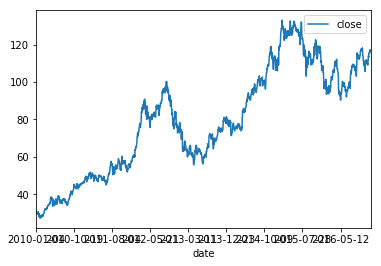

In [60]:
appl_prices.plot(x='date', y='close')